In [149]:
import pandas as pd
import numpy as np 
import math
import os
from sklearn.decomposition import PCA
from scipy.linalg import eigh
import requests
from bs4 import

### PCA Explanation

*La tecnica del PCA extrae los componentes principales de una matriz, en este caso extraera las componentes principales de la varianza historica de los forward rates.*

Suppose we have $\mathbb{X}$ a matrix $m \times n$ where each row represents a forward rate and each column is a day. 

Now, we compute the covariance matrix $M_{\mathbb{X}}$ such that: 

$$M_{\mathbb{X}} = \frac{1}{n} \mathbb{X}\mathbb{X}^T$$

The goal of the PCA is to find a matrix $\mathbb{P}$ in $\mathbb{Y} = \mathbb{P}  \mathbb{X}$ such that $M_{\mathbb{Y}} = \frac{1}{n} \mathbb{Y}\mathbb{Y}^T \text{ is diagonal. }$

*Es decir, buscamos una base $\mathbb{Y}$ donde la covarianza de las observaciones asociadas sea una matriz diagonal.*

$$M_{\mathbb{Y}} = \frac{1}{n} \mathbb{Y}\mathbb{Y}^T = \mathbb{P}\left( \mathbb{E} \mathbb{D}\mathbb{E}^T \right) \mathbb{P}^T$$

where: 
- $\mathbb{E}$ is the eigenvectors matrix
- $\mathbb{D}$ is the eigenvalues matrix

Clearly, if $\mathbb{P} = \mathbb{E}^T$ then: 

$$M_{\mathbb{Y}} = \mathbb{D}$$


### Using PCA in Heath, Jarrow and Morton Model

There are two ways to use HJM. 

- Choose the volatility structure $\nu_i(t, T)$ a priori to be sufficiently 'nice' to make a tractable model. 
- Choose a volatility structure matching data. This is where __PCA comes in__. 

<u>Assumptions:</u>

We will assume that volatility structure of the forward rate curve only depends on the time to maturity: 

$$\nu = \nu(T-t)$$

Model Dynamics: 

$$dF(t, T) = m(t,T)dt + \sum_{i = 1}^{N} \nu_i(T-t)dXi$$

Where:
- $dXi$ are uncorrelated
- $F(t, T)$ is the __instantaneous forward rate__, i.e. rate that one can contract at time $t$ on a riskless loan beginning at $T$ and returned an instant later. 

We have:

$$m(t, T) = \sum_{i = i}^{N} \nu_{i}(t, T)\int_{t}^{T}\nu_{i}(t, s)ds$$

Now suppose we have found the covariance matrix $\mathbb{M}$ for the changes in the 1M, 3M, 1Y, 5Y and 10Y for example (5 maturities in total for this case.)

This $5 \times 5$ matrix will have $5$ eigenvalues $\lambda_i$ and eigenvectors $v_i \in \mathbb{R}^5$. 

<u>Interpretaion:</u> The $k^{th}$ entry of the $v_i$ eigenvector corresponds to the $i^{th}$ principal component of the movement of the forward interest rate with $k^{th}$ maturity. 

The result of this analysis is: 

$$\sigma_k^2 = \sum_{j = 1}^{5} \lambda_j v_{jk}^2$$

Where $v_{jk}$ is the $k$-entry of the $j$-eigenvector. 

The variance has been decomposed in its principal components.

In rates analysis we choose normally $3$. 

<u>Final Result:</u>

$$\nu_i(\tau_j) = \sqrt{\lambda_i}(\vec{v_i})_j$$

First of all, we will retrieve __Bank of England forward rate curve__, clean the data and manipulate it.

<AxesSubplot:xlabel='years:'>

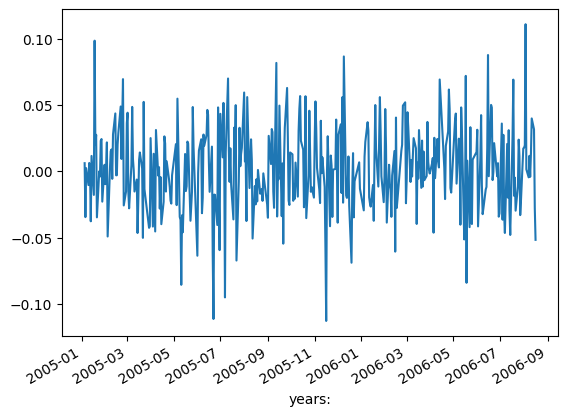

In [166]:
path = "/Users/educontreras/PycharmProjects/Fixed-Income/BoE Yield Curve"
dir_list = os.listdir(path)
for element in dir_list:
    if element != '.DS_Store':
        frames.append(pd.read_excel(f"{path}/{element}",index_col=0, header=3, sheet_name=2))
df = pd.concat(frames)
#df.dropna(how = "any", inplace = True)
#df = df.sort_index().iloc[:,:20].drop_duplicates().pct_change()
#df.dropna(how = "all", inplace= True)
df = (df - df.shift(1)).iloc[:, :50]
df.dropna(how = "all", inplace = True)
df.iloc[:400, 6].plot()

### Applying PCA to Forward Rates

We could use the __sklearn.decomposition.PCA__ imported before, but instead, we will compute everything from scratch using the __numpy.linalg.eig__  package to compute eigenvectors and eigenvalues from the covariance matrix. 


In [167]:
cov_matrix_array = df.cov().to_numpy()
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix_array)
df_eigval = pd.DataFrame({"Eigenvalues":eigenvalues}, index=range(1,51))
df_eigval["Explained proportion"] = df_eigval["Eigenvalues"] / np.sum(df_eigval["Eigenvalues"])
df_eigval.style.format({"Explained proportion": "{:.2%}"})

,Eigenvalues,Explained proportion
1,0.112036,82.37%
2,0.015397,11.32%
3,0.004889,3.59%
4,0.002312,1.70%
5,0.000831,0.61%
6,0.000385,0.28%
7,0.000122,0.09%
8,0.000031,0.02%
9,0.000009,0.01%
10,0.000003,0.00%


In [192]:
df_vol_structure = pd.DataFrame(columns = df.columns, index = range(1, 4))
for component in range(3):
    df_vol_structure.iloc[component, :] = math.sqrt(eigenvalues[component])*eigenvectors[component]
df_vol_structure = df_vol_structure.T

<AxesSubplot:>

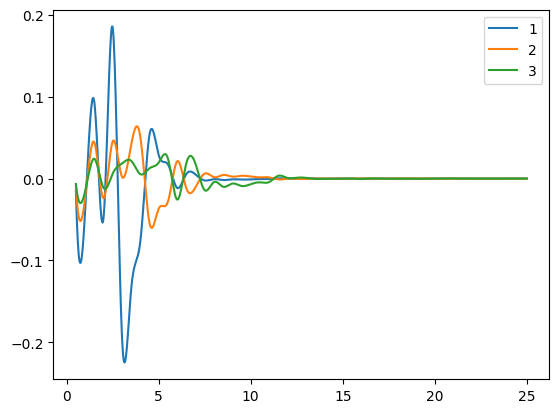

In [209]:
df_vol_interpolated = df_vol_structure.copy()
numb_steps = 1000
indexes = list(df_vol_structure.index)
L = np.linspace(indexes[0], indexes[-1], num = numb_steps)
for element in L:
    if element not in indexes:
        df_vol_interpolated.loc[element, :] = [np.nan for col in df_test.columns]
df_vol_interpolated.sort_index(inplace = True)
df_vol_interpolated = df_vol_interpolated.apply(pd.to_numeric)
df_vol_interpolated.interpolate(method='polynomial', order=3, inplace = True)
df_vol_interpolated.plot()

So here are the __three principal components per time to maturity__: 

In [176]:
df_vol_structure.T

,1,2,3
0.5,-0.014905,-0.009467,-0.006576
1.0,-0.040082,-0.023702,-0.015458
1.5,0.093537,0.044477,0.024248
2.0,-0.048331,-0.024046,-0.011362
2.5,0.184373,0.04539,0.006089
3.0,-0.191094,0.002599,0.018363
3.5,-0.136128,0.040606,0.021787
4.0,-0.076724,0.051115,0.005356
4.5,0.053664,-0.054209,0.012589
5.0,0.028529,-0.036604,0.019552


<AxesSubplot:>

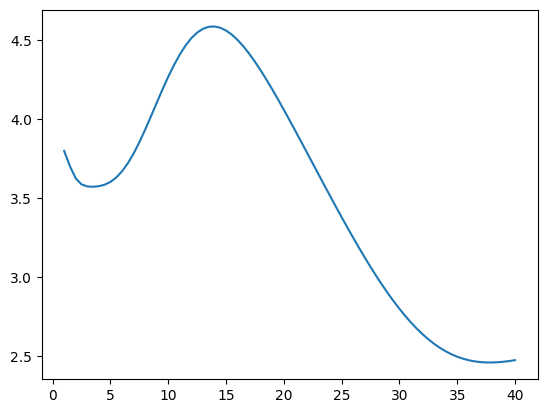

In [211]:
path = "/Users/educontreras/PycharmProjects/Fixed-Income/BoE Yield Curve/2015-2022.xlsx"
df_ir = pd.read_excel(path,index_col=0, header=3, sheet_name=2)
last_values = df_ir.iloc[-1, : ].plot()